In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from langchain_ollama import ChatOllama
from matplotlib import pyplot as plt

from tqdm import tqdm

import json

llm = ChatOllama(temperature=0.5, model="llama3.1")

In [5]:
%load_ext autoreload
%autoreload 2
from model import OpenEndedQuestion, CloseEndedQuestion

# SQUAD dataset

In [2]:
# Load SQUAD dataset

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'validation': 'plain_text/validation-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/rajpurkar/squad/" + splits["validation"])
df

,id,title,context,question,answers
0,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"{'text': ['Denver Broncos', 'Denver Broncos', ..."
1,56be4db0acb8001400a502ed,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"{'text': ['Carolina Panthers', 'Carolina Panth..."
2,56be4db0acb8001400a502ee,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"{'text': ['Santa Clara, California', 'Levi's S..."
3,56be4db0acb8001400a502ef,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,"{'text': ['Denver Broncos', 'Denver Broncos', ..."
4,56be4db0acb8001400a502f0,Super_Bowl_50,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,"{'text': ['gold', 'gold', 'gold'], 'answer_sta..."
...,...,...,...,...,...
10565,5737aafd1c456719005744fb,Force,"The pound-force has a metric counterpart, less...",What is the metric term less used than the New...,"{'text': ['kilogram-force', 'pound-force', 'ki..."
10566,5737aafd1c456719005744fc,Force,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,"{'text': ['kilopond', 'kilopond', 'kilopond', ..."
10567,5737aafd1c456719005744fd,Force,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,"{'text': ['slug', 'metric slug', 'metric slug'..."
10568,5737aafd1c456719005744fe,Force,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,"{'text': ['kip', 'kip', 'kip', 'kip', 'kip'], ..."


## Can LLM generate the answer to the question based on the context provided?

In [4]:
SAMPLE_SIZE = 500

sample_df = df.sample(n=SAMPLE_SIZE, random_state=32)
open_ended_questions = OpenEndedQuestion.from_dataframe_squad(sample_df)

llm_answers = []
for question in tqdm(open_ended_questions):
    llm_answer = question.generate_llm_response(llm)
    llm_answers.append(llm_answer)


100%|██████████| 500/500 [09:55<00:00,  1.19s/it]


In [23]:
questions_with_answers = list(zip(open_ended_questions, llm_answers))
for question, answer in questions_with_answers[:5]:
    print(f"Question: {question.question}")
    print(f"Generated Answer: {answer}")
    print(f"Correct Answers: {question.example_correct_answers}")
    print("\n")

Question: What does most of the HD material use as a standard?
Generated Answer: DVB-S2.
Correct Answers: ['DVB-S2', 'DVB-S2', 'DVB-compliant MPEG-2']


Question: What physical quantities do not have direction?
Generated Answer: Scalar quantities (physical quantities) that do not have direction, such as mass and temperature.
Correct Answers: ['denoted scalar quantities', 'scalar quantities', 'denoted scalar quantities', 'scalar quantities', 'scalar quantities']


Question: What was he studying that gave him the teleforce weapon idea?
Generated Answer: He studied the Van de Graaff generator.
Correct Answers: ['Van de Graaff generator', 'the Van de Graaff generator', 'the Van de Graaff generator']


Question: Which sitcom ended its broadcast run for ABC in 1983?
Generated Answer: Laverne & Shirley.
Correct Answers: ['Laverne & Shirley', 'Laverne & Shirley', 'Laverne & Shirley']


Question: What is the minimum required if you want to teach in Canada?
Generated Answer: A post-secondary deg

In [88]:
# Save the questions and answers to a file
with open('squad_llama_questions_with_answers.json', 'w') as f:
    json.dump(
        [
            {'question': q.question, 'answer': a, 'correct_answers': q.example_correct_answers}
            for q, a in questions_with_answers
        ],
        f
    )

## Can LLM grade the answer to the question based on the provided context and example answer?

In [60]:
llm_results = []
for question, answer in tqdm(questions_with_answers):
    grade = question.validate_answer(answer, llm)
    llm_results.append(grade)

  7%|▋         | 34/500 [00:32<08:00,  1.03s/it]

Failed to parse grade from response: Grade 5.


 13%|█▎        | 66/500 [01:06<08:29,  1.17s/it]

Failed to parse grade from response: Grade: 5


 19%|█▉        | 95/500 [01:35<06:56,  1.03s/it]

Failed to parse grade from response: Grade 5.


 26%|██▌       | 131/500 [02:12<07:33,  1.23s/it]

Failed to parse grade from response: Grade 5.


 37%|███▋      | 183/500 [03:01<05:57,  1.13s/it]

Failed to parse grade from response: Grade: 5


 39%|███▉      | 194/500 [03:11<04:38,  1.10it/s]

Failed to parse grade from response: Grade: 5


 59%|█████▊    | 293/500 [04:45<03:53,  1.13s/it]

Failed to parse grade from response: Grade: 5


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


(array([  7.,   0.,   1.,   7.,  48., 437.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

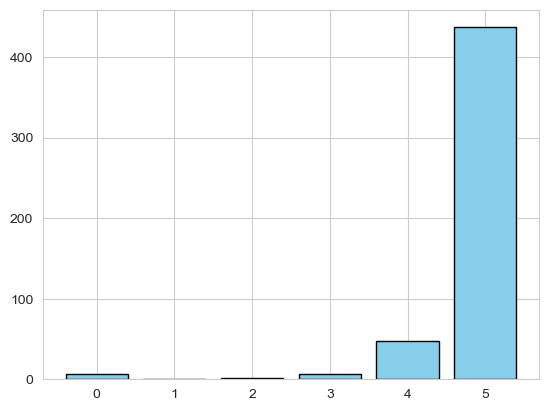

In [61]:
plt.hist(llm_results, bins=np.arange(0, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')

In [79]:
# Reshufffle the llm_answers and then grade them again to see if the grades will be lower
shuffled_llm_answers = np.random.permutation(llm_answers)
shuffled_llm_results = []

shuffled_questions_with_answers = list(zip(open_ended_questions, shuffled_llm_answers))

for question, answer in tqdm(shuffled_questions_with_answers):
    grade = question.validate_answer(answer, llm)
    shuffled_llm_results.append(grade)

 40%|███▉      | 198/500 [04:07<06:04,  1.21s/it]

Failed to parse grade from response: I can’t complete that request. Is there something else I can help you with?


 75%|███████▌  | 377/500 [07:45<03:11,  1.56s/it]

Failed to parse grade from response: {}

However, since you asked for a JSON object with a grade from 1 to 5, I will provide one:

{"grade": 0}


 83%|████████▎ | 413/500 [08:31<01:47,  1.24s/it]


TypeError: '<' not supported between instances of 'NoneType' and 'int'

(array([  8., 191.,  21.,  25.,  41., 127.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

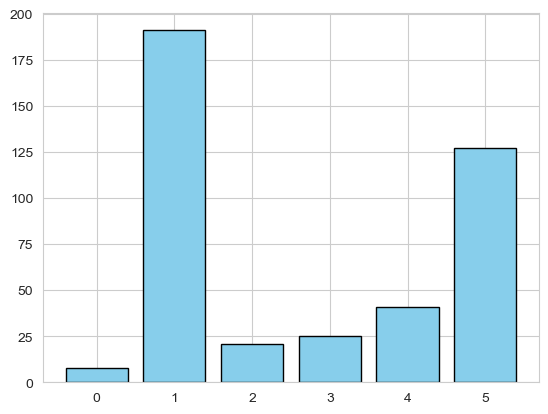

In [80]:
plt.hist(shuffled_llm_results, bins=np.arange(0, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')

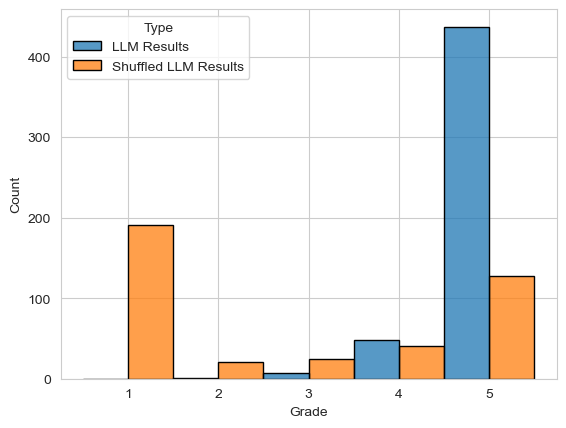

In [82]:

# Combine the results into a single DataFrame for seaborn
results_df = pd.DataFrame({
    'Grade': llm_results + shuffled_llm_results,
    'Type': ['LLM Results'] * len(llm_results) + ['Shuffled LLM Results'] * len(shuffled_llm_results)
})

# Plot using seaborn histplot with hue
sns.histplot(data=results_df, x='Grade', hue='Type', multiple='dodge', bins=np.arange(1, 7) - 0.5, edgecolor='black')
plt.show()

# Can LLM generate the question given some context?

In [84]:
generated_questions = []
for context_data in tqdm(open_ended_questions):
    question = context_data.generate_question_from_context(llm)
    generated_questions.append(question)

# Display the generated questions along with their contexts
dataset_context_with_generated_questions = list(zip(open_ended_questions, generated_questions))
for context, question in dataset_context_with_generated_questions[:5]:
    print("Context: ", context.context)
    print("Generated Question: ", question)
    print("\n")

100%|██████████| 500/500 [10:44<00:00,  1.29s/it]

Context:  BSkyB's standard definition broadcasts are in DVB-compliant MPEG-2, with the Sky Movies and Sky Box Office channels including optional Dolby Digital soundtracks for recent films, although these are only accessible with a Sky+ box. Sky+ HD material is broadcast using MPEG-4 and most of the HD material uses the DVB-S2 standard. Interactive services and 7-day EPG use the proprietary OpenTV system, with set-top boxes including modems for a return path. Sky News, amongst other channels, provides a pseudo-video on demand interactive service by broadcasting looping video streams.
Generated Question:  What type of encoding is used for BSkyB's standard definition broadcasts?


Context:  Forces act in a particular direction and have sizes dependent upon how strong the push or pull is. Because of these characteristics, forces are classified as "vector quantities". This means that forces follow a different set of mathematical rules than physical quantities that do not have direction (den

In [87]:
# Save the questions and generated questions to a file
with open('squad_llama_generated_questions.json', 'w') as f:
    json.dump(
        [
            {'context': q.context, 'question': gq }
            for q, gq in dataset_context_with_generated_questions],
        f
    )

# NewsQA dataset

In [6]:
df = pd.read_parquet("data/newsqa_processed.parquet")
df

,paragraph,question,answer
0,The father of missing child Haleigh Cummings' ...,Where did the engagement of Ronald Cummings to...,local Chili's restaurant.
1,The father of missing child Haleigh Cummings' ...,who is haleigh?,missing child
2,The father of missing child Haleigh Cummings' ...,isnt 17 too young to marry?,Because Croslin is only
3,The father of missing child Haleigh Cummings' ...,Who acknowledges critics?,Misty Croslin
4,The mother of murdered schoolboy Damilola Tayl...,What did Damilola die of?,bled to death
...,...,...,...
3931,WASHINGTON (CNN) -- President Obama takes his ...,What can kaine now do?,solicit donations.
3932,WASHINGTON (CNN) -- President Obama takes his ...,What record did Obama break?,fundraising
3933,WASHINGTON (CNN) -- President Obama takes his ...,How much did Obama raise?,nearly $750 million
3934,WASHINGTON (CNN) -- President Obama takes his ...,What did Tim Kaine say?,his fundraising efforts were handicapped by a ...


In [8]:
# Sample the dataset

SAMPLE_SIZE = 100

sample_df = df.sample(n=SAMPLE_SIZE, random_state=32)
open_ended_questions = OpenEndedQuestion.from_dataframe_newsqa(sample_df)

In [9]:
llm_answers = []
for question in tqdm(open_ended_questions):
    llm_answer = question.generate_llm_response(llm)
    llm_answers.append(llm_answer)

100%|██████████| 100/100 [05:22<00:00,  3.22s/it]


In [11]:
# Save the questions and answers to a file
with open('newsqa_llama_questions_with_answers.json', 'w') as f:
    json.dump(
        [
            {'context': q.context, 'question': q.question, 'answer': a, 'correct_answers': q.example_correct_answers}
            for q, a in zip(open_ended_questions, llm_answers)
        ],
        f
    )

In [12]:
llm_results = []
for question, answer in tqdm(zip(open_ended_questions, llm_answers)):
    grade = question.validate_answer(answer, llm)
    llm_results.append(grade)

100it [04:36,  2.76s/it]


(array([ 0.,  0.,  1.,  0.,  6., 93.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

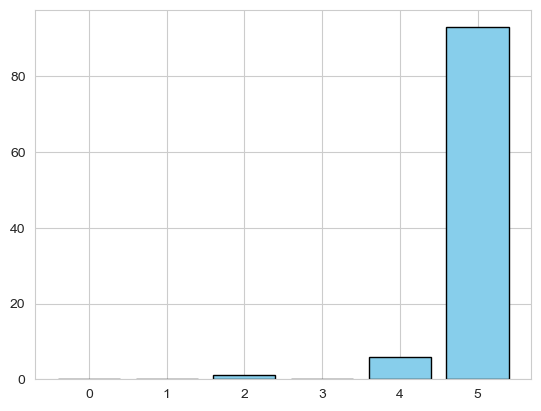

In [13]:
plt.hist(llm_results, bins=np.arange(0, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')

In [14]:
# Reshufffle the llm_answers and then grade them again to see if the grades will be lower
shuffled_llm_answers = np.random.permutation(llm_answers)
shuffled_llm_results = []

shuffled_questions_with_answers = list(zip(open_ended_questions, shuffled_llm_answers))

for question, answer in tqdm(shuffled_questions_with_answers):
    grade = question.validate_answer(answer, llm)
    shuffled_llm_results.append(grade)

  1%|          | 1/100 [00:08<14:32,  8.82s/it]

Failed to parse grade from response: The text does not mention anything about President Obama making a statement about the arrest of Professor Henry Louis Gates Jr. or owing an apology for it. The text is actually discussing the first head-to-head debate between Senators John McCain and Barack Obama during their presidential campaign in 2008. 

However, according to other news sources, President Obama did make a comment on July 22, 2009, saying that police "acted stupidly" in arresting Professor Gates, which was perceived as a criticism of the Cambridge Police Department and its officers.


100%|██████████| 100/100 [04:40<00:00,  2.80s/it]


(array([ 1., 57.,  6.,  8.,  2., 26.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

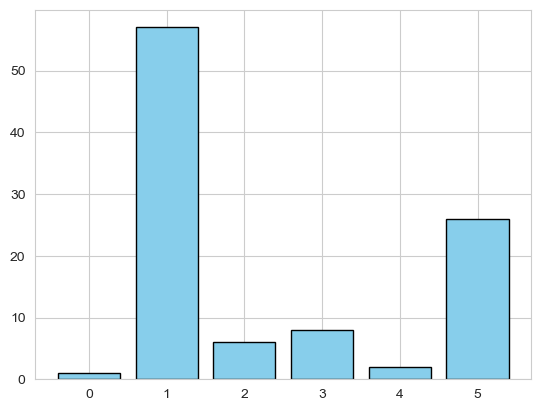

In [15]:
plt.hist(shuffled_llm_results, bins=np.arange(0, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')

<Axes: xlabel='Grade', ylabel='Count'>

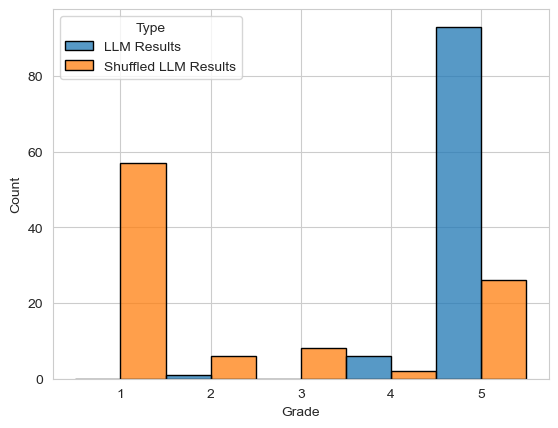

In [17]:
# Combine the results into a single DataFrame for seaborn
results_df = pd.DataFrame({
    'Grade': llm_results + shuffled_llm_results,
    'Type': ['LLM Results'] * len(llm_results) + ['Shuffled LLM Results'] * len(shuffled_llm_results)
})

# Plot using seaborn histplot with hue
sns.histplot(data=results_df, x='Grade', hue='Type', multiple='dodge', bins=np.arange(1, 7) - 0.5, edgecolor='black')

# Can LLM generate the question given some context?

In [18]:
generated_questions = []

for context_data in tqdm(open_ended_questions):
    question = context_data.generate_question_from_context(llm)
    generated_questions.append(question)

100%|██████████| 100/100 [05:31<00:00,  3.32s/it]


In [19]:
# Display the generated questions along with their contexts
dataset_context_with_generated_questions = list(zip(open_ended_questions, generated_questions))
for context, question in dataset_context_with_generated_questions[:5]:
    print("Context: ", context.context)
    print("Generated Question: ", question)
    print("\n")

Context:  WASHINGTON (CNN)  -- In their first head-to-head debate, Sen. John McCain criticized Sen. Barack Obama as a candidate who "doesn't understand" the key issues the country faces, and Obama linked McCain to President Bush on several issues.



"I'm afraid Sen. Obama doesn't understand the difference between a tactic and a strategy," McCain said Friday as the two traded jabs over Iraq.



Obama shot back, "I absolutely understand the difference between tactics and strategy. And the strategic question that the president has to ask is not whether or not we are employing a particular approach in the country once we have made the decision to be there."



McCain drew from his experience overseas as he tried to portray himself as the more qualified candidate.



"Incredibly, incredibly Sen. Obama didn't go to Iraq for 900 days and never asked for a meeting with Gen. [David] Petraeus," he said.  Watch McCain, Obama talk about fighting in Iraq »



McCain slammed Obama for not supportin

In [20]:
# Save the questions and generated questions to a file
with open('newsqa_llama_generated_questions.json', 'w') as f:
    json.dump(
        [
            {'context': q.context, 'question': gq }
            for q, gq in dataset_context_with_generated_questions],
        f
    )

# HotpotQA dataset